In [1]:
"""
Validate DA results using independent CaCO3 data

# steps
1. DA
2. Read prior CaCO3: prePETM peakPETM
3. Read posterior CaCO3: prePETM peakPETM
4. Calculate
"""

from DeepDA_lib import modules_nc
from DeepDA_lib import DeepDA_psm
from scipy import stats
import shutil
import h5py
import yaml
import numpy as np
import pandas
import os
from netCDF4 import Dataset
from sys import platform as sys_pf
import matplotlib.pyplot as plt
if sys_pf == 'darwin':
    import matplotlib
    matplotlib.use("TkAgg")
    import matplotlib.pyplot as plt
%matplotlib inline

try:
    import bayspline
except ImportError as e1:
    print('Warning:', e1)
try:
    import bayspar
except ImportError as e2:
    print('Warning:', e2)
try:
    import bayfox
except ImportError as e3:
    print('Warning:', e3)
try:
    import baymag
except ImportError as e4:
    print('Warning:', e4)

print('>>  Import package => OKAY')
print('')
#####################    User defined start   #####################


en = 'petmproxy3slices_v0.0.12.csv_petm11_v12_20200427_all_glassy_preP2_noCaCO3'    # prePETM
#en = 'petmproxy3slices_v0.0.13.csv_petm15_v12_20200616_all_glassy_pre_noCaCO3'    # prePETM
en2 = 'petmproxy3slices_v0.0.12.csv_petm9_v12_20200427_all_glassy_pre_peak_noCaCO3' # peakPETM

dum_jmax = 36
dum_imax = 36
dum_ijmax = dum_imax * dum_jmax
AnalysisStd = True   # True: standardize; False: use raw analysis data
#####################    User defined end     #####################
config_name_f = "DeepDA_config.yml"
f = open(config_name_f, 'r')
yml_dict_f = yaml.load(f, Loader=yaml.FullLoader)
f.close()

dir_data_save = yml_dict_f['core']['wrkdir']
MC_dir =  dir_data_save + '/' + en + '/'
MC_dir2=  dir_data_save + '/' + en2 + '/'

config_name = dir_data_save + '/' + en + '.yml'
f = open(config_name, 'r')
yml_dict = yaml.load(f, Loader=yaml.FullLoader)
f.close()
print('>>  Loading configuration file => OKAY')
print('')
# Read parameters from configurations
MCn = yml_dict['MonteCarlo']['number']
nens = yml_dict['core']['nens']

nexp = yml_dict['core']['nexp']
dir_data_save = yml_dict['core']['wrkdir']

recon_period = yml_dict['core']['recon_period']
recon_timescale = yml_dict['core']['recon_timescale_interval']
recon_period_full = np.arange(recon_period[0],recon_period[1]+1,recon_timescale)
recon_period_len = recon_period_full.shape[0]
recon_timescale = yml_dict['core']['recon_timescale_interval']
save_ens_full = yml_dict['core']['save_ens_full']
proxy_assim2 = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_assim2']
proxy_psm_type    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_psm_type']
proxy_err_eval   = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_err_eval']
lon_label = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['lon_label']
lat_label = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['lat_label']

proxy_frac      = yml_dict['proxies']['proxy_frac']
prior_source = yml_dict['prior']['prior_source'] #
dum_lon_offset = yml_dict['prior'][prior_source]['dum_lon_offset'] # longitude offset
limit_hard_keys = list(yml_dict['prior'][prior_source]['limit_hard'].keys())
print(limit_hard_keys)

data_period_id    = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['data_period_id']
data_period_idstd = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['data_period_idstd']
recon_period = yml_dict['core']['recon_period']
recon_timescale = yml_dict['core']['recon_timescale_interval']
recon_period_full = np.arange(recon_period[0],recon_period[1]+1,recon_timescale)
recon_period_len = recon_period_full.shape[0]
geologic_age = yml_dict['core']['geologic_age']

dir_proxy         = yml_dict['core']['proxy_dir']
dir_proxy_raw    = dir_proxy +'/'+ yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['dbversion']

# read preprior HDF5 file
dir_proxy_data = dir_data_save +'/'+ yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['dbversion']
proxy_err_eval = yml_dict['proxies'][yml_dict['proxies']['use_from'][0]]['proxy_err_eval']

# ========= dataset for plot =========
cGENIEGrid = yml_dict['core']['proj_dir'] + '/data_misc/cGENIEGrid.csv'
cGENIEGrid = pandas.read_csv(cGENIEGrid)
cGENIEGridB_lat36 = cGENIEGrid['lat']
cGENIEGridB_lon36 = cGENIEGrid['lon']
cGENIEGrid = cGENIEGrid.to_numpy()
#print('>>  OKAY.')

# Read global mean and plot to show results
########## Prior #########
prior_state_variable = yml_dict['prior'][prior_source]['state_variable']  # note: ['2d': xxx; '3d': xxx]
dum_lon_offset = yml_dict['prior'][prior_source]['dum_lon_offset'] # longitude offset
# ========= Monte Carlo =========
local_rad_list = yml_dict['core']['local_rad_list'] #
locRadn= len(local_rad_list)
local_rad_list = np.asarray(local_rad_list)
#print(local_rad_list)
#print(locRadn)
proxy_frac_list   = yml_dict['proxies']['proxy_frac']
proxy_fracn = len(proxy_frac_list)
proxy_frac_list = np.asarray(proxy_frac_list)

Rscale_list = yml_dict['core']['Rscale']
Rscalen = len(Rscale_list)
Rscale_list = np.asarray(Rscale_list)

# save prior variable list
prior_variable_dict = []  # variable list
prior_nc_file_list = []  # nc file list
prior_variable_dict_3d = []  # variable list
prior_nc_file_list_3d = []  # nc file list

for key, value in prior_state_variable.items():
    nc_keyvalue = prior_state_variable[key]['ncname']  # note: 2d dict
    print('>>  nc_keyvalue {}...'.format(nc_keyvalue))
    for key1, value1 in nc_keyvalue.items():
        print('>>  {}: {}'.format(key1,value1))
        for i in range(len(prior_state_variable[key][value1])):
            if key in ['2d']:
                prior_variable_dict.append(prior_state_variable[key][value1][i])
                prior_nc_file_list.append(key1+'/'+value1+'.nc')
            elif key in ['3d']:
                prior_variable_dict_3d.append(prior_state_variable[key][value1][i])
                prior_nc_file_list_3d.append(key1+'/'+value1+'.nc')

# variable list
prior_variable_len = len(prior_variable_dict)
prior_variable3d_len = len(prior_variable_dict_3d)
print('>>  Number of 2d prior variables is: {}. List:'.format(prior_variable_len))
print('      {}'.format(prior_variable_dict))
print('>>  Number of 3d prior variables is: {}. List:'.format(prior_variable3d_len))
print('      {}'.format(prior_variable_dict_3d))



Xa2d_full_np = np.full((locRadn,proxy_fracn,Rscalen,MCn*nens,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_mean_np = np.full((locRadn,proxy_fracn,Rscalen,MCn,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_std_np = np.full((locRadn,proxy_fracn,Rscalen,MCn,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_all_np = np.full((dum_jmax, dum_imax,locRadn,proxy_fracn,Rscalen,MCn, prior_variable_len, recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_allstd_np = np.full((dum_jmax, dum_imax, locRadn,proxy_fracn,Rscalen,MCn, prior_variable_len, recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_mean_np2 = np.full((locRadn,proxy_fracn,Rscalen,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)
Xa2d_std_np2 = np.full((locRadn,proxy_fracn,Rscalen,prior_variable_len,recon_period_len),np.nan)  # save mean of each variable (column) of each MC run (row)

for locRadi in range(locRadn):
    locRad = local_rad_list[locRadi]
    if locRad is None:
        locRadv = 0 # for filename only
    else:
        locRadv = locRad
    for proxy_fraci in range(proxy_fracn):
        proxy_frac = proxy_frac_list[proxy_fraci]
        
        for Rscalei in range(Rscalen):
            Rscale = Rscale_list[Rscalei]
            for MCi in range(MCn):
                # NetCDF file name
                filename_short = '_loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale),'_MC_' + str(MCi) 
                nc_filename = MC_dir + ''.join(filename_short) + '.nc'
                hdf5name    = MC_dir + ''.join(filename_short) + '.hdf5'
                
                print('>>  Read nc file: {}'.format(nc_filename))
                for Xa2d_vari in range(prior_variable_len):
                    Xa_full_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_full'
                    Xa_mean_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_mean'
                    Xa_variance_name_vari = prior_variable_dict[Xa2d_vari] +'_Xa_variance'
                    #print('>>  2d variable name {}'.format(Xa_mean_name_vari))
                    Xa_full_vari = Dataset(nc_filename).variables[Xa_full_name_vari][:]
                    Xa_mean_vari = Dataset(nc_filename).variables[Xa_mean_name_vari][:]
                    Xa_variance_vari = Dataset(nc_filename).variables[Xa_variance_name_vari][:]
                    
                    if prior_variable_dict[Xa2d_vari] in limit_hard_keys:
                        # some variables have hard limitation: e.g., CaCO3 = [0, 100]                        
                        lim_min = yml_dict['prior'][prior_source]['limit_hard'][prior_variable_dict[Xa2d_vari]]['lim_min']
                        lim_max = yml_dict['prior'][prior_source]['limit_hard'][prior_variable_dict[Xa2d_vari]]['lim_max']
                        #print('limit min {} and max {}'.format(lim_min, lim_max))
                        if lim_min:
                            if np.any(Xa_full_vari<lim_min):
                                Xa_full_vari[Xa_full_vari<lim_min] = lim_min
                                Xa_mean_vari = np.mean(Xa_full_vari,axis=2)
                                Xa_variance_vari = np.var(Xa_full_vari,axis=2)
                                print('>>    Force {} value to be >= {}'.format(prior_variable_dict[Xa2d_vari],lim_min))
                        if lim_max:
                            if np.any(Xa_full_vari>lim_max):
                                Xa_full_vari[Xa_full_vari>lim_max] = lim_max
                                Xa_mean_vari = np.mean(Xa_full_vari,axis=2)
                                Xa_variance_vari = np.var(Xa_full_vari,axis=2)
                                print('>>    Force {} value to be <= {}'.format(prior_variable_dict[Xa2d_vari], lim_max))
                                
                    for reconi in range(recon_period_len):
                        
                        Xa_full_reconi = Xa_full_vari[:,:,:,0,reconi].reshape((dum_ijmax,nens))
                        Xa_full_reconi_mean = np.nanmean(Xa_full_reconi,axis=0)
                        
                        Xa_mean_reconi = Xa_mean_vari[:,:,0,reconi]
                        Xa2d_all_np[:,:,locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = np.copy(Xa_mean_vari[:,:,0,reconi])
                        Xa_mean_reconi_mean = np.nanmean(Xa_mean_reconi)

                        Xa_variance_reconi = Xa_variance_vari[:,:,0,reconi]
                        Xa2d_allstd_np[:,:,locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = Xa_variance_vari[:,:,0,reconi]
                        Xa_std_reconi_mean = np.sqrt(np.nanmean(Xa_variance_reconi))
                        
                        #print('>>  reconi = {}, mean is {}, std is {}'.format(reconi, Xa_mean_reconi_mean, Xa_std_reconi_mean))
                        Xa2d_full_np[locRadi,proxy_fraci,Rscalei,MCi*nens:(MCi+1)*nens,Xa2d_vari,reconi] = Xa_full_reconi_mean
                        Xa2d_mean_np[locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = Xa_mean_reconi_mean
                        Xa2d_std_np[locRadi,proxy_fraci,Rscalei,MCi,Xa2d_vari,reconi] = Xa_std_reconi_mean
            print('First variable: all MC mean')
            print(Xa2d_mean_np[locRadi,proxy_fraci,Rscalei,:,0,0])
            
            Xa2d_all_np = np.ma.masked_where(Xa2d_all_np > 9.0e+36, Xa2d_all_np)
            Xa2d_allstd_np = np.ma.masked_where(Xa2d_all_np > 9.0e+36, Xa2d_allstd_np)
            for Xa2d_vari in range(prior_variable_len):
                for reconi in range(recon_period_len):
                    Xa2d_mean_np2[locRadi,proxy_fraci,Rscalei,Xa2d_vari,reconi] = np.nanmean(Xa2d_all_np[:,:,locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi])
                    Xa2d_std_np2[locRadi,proxy_fraci,Rscalei,Xa2d_vari,reconi] = np.sqrt(np.nanmean(Xa2d_allstd_np[:,:,locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi]))
            
            np.set_printoptions(precision=6, suppress=True)
            print('All variable. Mean of variables x reconi')
            print('{}'.format(Xa2d_mean_np2[locRadi,proxy_fraci,Rscalei,:,:]))

>>  Import package => OKAY

>>  Loading configuration file => OKAY

['sed_CaCO3', 'atm_pCO2']
>>  nc_keyvalue {'biogem': 'fields_biogem_2d', 'sedgem': 'fields_sedgem_2d'}...
>>  biogem: fields_biogem_2d
>>  sedgem: fields_sedgem_2d
>>  nc_keyvalue {'biogem': 'fields_biogem_3d'}...
>>  biogem: fields_biogem_3d
>>  Number of 2d prior variables is: 8. List:
      ['ocn_sur_temp', 'atm_pCO2', 'ocn_sur_sal', 'misc_pH', 'carb_sur_ohm_cal', 'sed_CaCO3', 'sed_CaCO3_13C', 'carb_ohm_cal']
>>  Number of 3d prior variables is: 0. List:
      []
>>  Read nc file: /mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.12.csv_petm11_v12_20200427_all_glassy_preP2_noCaCO3/_loc_0_proxy_frac_0.7_Rscale_1.0_MC_0.nc
>>    Force sed_CaCO3 value to be <= 100.0
>>  Read nc file: /mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.12.csv_petm11_v12_20200427_all_glassy_preP2_noCaCO3/_loc_0_proxy_frac_0.7_Rscale_1.0_MC_1.nc
>>    Force sed_CaCO3 value to be <= 100.0
>>  Read nc file: /mnt/d/DeepDA/wrk/petmproxy3slices_v0.0.12.csv_petm11_v

DA - Summary of global mean and standard deviation

ocn_sur_temp
  _locR 0 proxy_frac 0.7 scaled r 1.0
    28.881 ± 0.573: prePETM
misc_pH
  _locR 0 proxy_frac 0.7 scaled r 1.0
    7.627 ± 0.039: prePETM
sed_CaCO3
  _locR 0 proxy_frac 0.7 scaled r 1.0
    66.279 ± 0.936: prePETM


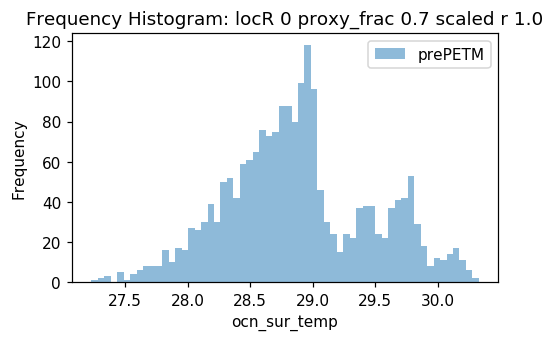

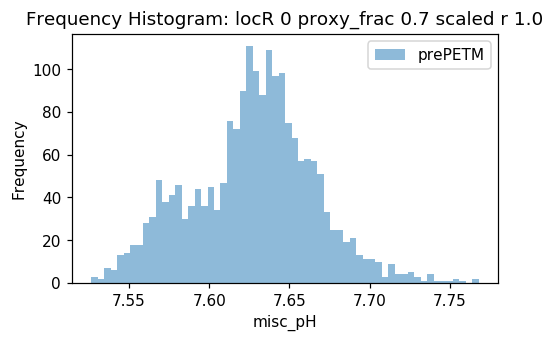

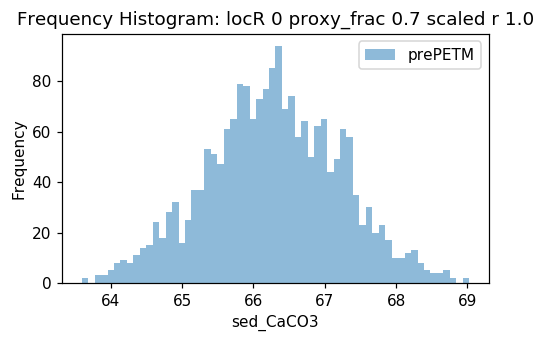

In [2]:
# Calculate mean and std of each variable for each time slice
# plot the ensemble values
#####################    User defined start   #####################
label_all = ('prePETM', 'peakPETM', 'PETM','postPETM')
label_all_len = len(label_all)
warmcomp = [0,1]  # ID for petm warming
print('DA - Summary of global mean and standard deviation')
print('')
#####################    User defined end     #####################

for locRadi in range(locRadn):
    locRad = local_rad_list[locRadi]
    if locRad is None:
        locRadv = 0 # for filename only
    else:
        locRadv = locRad
        
    for proxy_fraci in range(proxy_fracn):
        proxy_frac = proxy_frac_list[proxy_fraci]
        
        for Rscalei in range(Rscalen):
            Rscale = Rscale_list[Rscalei]
            
            # 2d variables
            for Xa2d_vari in range(prior_variable_len):
                if Xa2d_vari in [0,3,5]:
                    print(prior_variable_dict[Xa2d_vari])

                    sst_std_mc = np.std(Xa2d_mean_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,:],axis=0)
                    print('  _locR '+str(locRadv)+' proxy_frac '+str(proxy_frac)+' scaled r '+str(Rscale))

                    for reconi in range(recon_period_len):

                        meani = np.nanmean(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi])
                        stdi = np.std(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi])
                        if recon_period_len>2:
                            warmpeak = Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,1]-Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,0]
                            warmbody = Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,2]-Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,0]
                            warmpeakmean = np.nanmean(warmpeak)
                            warmpeakstd = np.std(warmpeak)
                            warmbodymean = np.nanmean(warmbody)
                            warmbodystd = np.std(warmbody)

                        if prior_variable_dict[Xa2d_vari] in ['atm_pCO2']:
                            print('    {:.3f} ± {:.3f}: {}'.format(meani*1e6, stdi*1e6, label_all[reconi]))
                        else:
                            print('    {:.3f} ± {:.3f}: {}'.format(meani, stdi, label_all[reconi]))
                    if recon_period_len>2:
                        print('    warming peak: {:.6f} ± {:.6f}'.format(warmpeakmean,warmpeakstd))
                        print('    warming body: {:.6f} ± {:.6f}'.format(warmbodymean,warmbodystd))

                    plt.rcParams.update({'figure.figsize':(5,3), 'figure.dpi':110})
                    fig = plt.figure()
                    for reconi in range(recon_period_len):
                        kwargs = dict(alpha=0.5, bins=60)
                        if prior_variable_dict[Xa2d_vari] in ['atm_pCO2']:
                            plt.hist(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi]*1e6, **kwargs, label = label_all[reconi])
                            plt.gca().set(xlabel = prior_variable_dict[Xa2d_vari]+ ' (ppm)');
                        else:
                            plt.hist(Xa2d_full_np[locRadi,proxy_fraci,Rscalei,:,Xa2d_vari,reconi], **kwargs, label = label_all[reconi])
                            plt.gca().set(xlabel = prior_variable_dict[Xa2d_vari]);
                        plt.gca().set(title='Frequency Histogram: locR '+str(locRadv)+' proxy_frac '+str(proxy_frac)+' scaled r '+str(Rscale), ylabel='Frequency');

                        plt.legend();

In [3]:
'''
read prior and posterior of validate_variable at sedcores
'''
#####################    User defined start   #####################
verbose = True
data_psm_type = 'caco3'
#####################    User defined end     #####################
print(' ########## Read proxies database ########## ')
print('')
### read proxies database ###
proxies = pandas.read_csv(dir_proxy_raw)
proxies_len0 = len(proxies)
proxies_validate = proxies[proxies.Type == validate_variable].reset_index(drop=True)
proxies_validaten = len(proxies_validate)

print('len of validate proxy is {}'.format(proxies_validaten))
#print(proxies_validate)
print('DA - Read proxy, prior, and posterior')
print('')

# Prepare empty matrix for saving the data of proxy, prior, and posterior
ob_stat = np.full((locRadn,proxy_fracn,Rscalen, 2, proxies_validaten), np.nan)
xb_stat = np.full((locRadn,proxy_fracn,Rscalen, 2, 2, proxies_validaten), np.nan)   # save full prior for withhold data
xa_stat = np.full((locRadn,proxy_fracn,Rscalen, 2, 2, proxies_validaten), np.nan)
# calculate each Monte Carlo runs
for locRadi in range(locRadn):
    locRad = local_rad_list[locRadi]
    if locRad is None:
        locRadv = 0 # for filename only
    else:
        locRadv = locRad        
    for proxy_fraci in range(proxy_fracn):
        proxy_frac = proxy_frac_list[proxy_fraci]
        
        for Rscalei in range(Rscalen):
            Rscale = Rscale_list[Rscalei]
            
            ob_stat[locRadi][proxy_fraci][Rscalei][0][:] = proxies_validate.prePETMmean[:]
            ob_stat[locRadi][proxy_fraci][Rscalei][1][:] = proxies_validate.PETMmean[:]            
            print(ob_stat[locRadi][proxy_fraci][Rscalei][:][:])
            
            MCi =  0
            filename_short = '_loc_', str(locRadv),'_proxy_frac_', str(proxy_frac),'_Rscale_',str(Rscale),'_MC_' + str(MCi)
            nc_filename = MC_dir + ''.join(filename_short) + '.nc'
            nc_filename2 = MC_dir2 + ''.join(filename_short) + '.nc'
            
            for key, value in proxy_assim2.items():
                if data_psm_type in value:
                    key0 = key
                    psm_required_variable_key = list(yml_dict['psm'][proxy_psm_type[key]]['psm_required_variables'].keys())[0]
                    xb_keym = psm_required_variable_key+'_Xb_mean'
                    xb_keyv = psm_required_variable_key+'_Xb_variance'
                    Xb_full_field01  = Dataset(nc_filename).variables[xb_keym] # prePETM ensemble mean
                    Xb_full_field01v = Dataset(nc_filename).variables[xb_keyv] # prePETM ensemble variance
                    Xb_full_field02  = Dataset(nc_filename2).variables[xb_keym] # peakPETM ensemble mean
                    Xb_full_field02v  = Dataset(nc_filename2).variables[xb_keyv] # peakPETM ensemble variance
                    
                    xa_keym = psm_required_variable_key+'_Xa_mean'
                    xa_keyv = psm_required_variable_key+'_Xa_variance'
                    Xa_full_field01  = Dataset(nc_filename).variables[xa_keym] # prePETM ensemble mean
                    Xa_full_field01v = Dataset(nc_filename).variables[xa_keyv] # prePETM ensemble variance
                    Xa_full_field02  = Dataset(nc_filename2).variables[xa_keym] # peakPETM ensemble mean
                    Xa_full_field02v = Dataset(nc_filename2).variables[xa_keyv] # peakPETM ensemble variance

            for j in range(proxies_validaten):
                # read lon lat for each line of proxy
                dum_lat = proxies_validate[lat_label][j]  # (paleo)latitude of this site
                dum_lon = proxies_validate[lon_label][j]  # (paleo)longitude of this site

                lonlat = modules_nc.cal_find_ij(dum_lon,dum_lat,dum_lon_offset,dum_imax,dum_jmax)
                # output [lon, lat], 
                # lon ranges from 0 (-180) to 35 (180), lat ranges from 0 (-90) to 35 (90)
                
                xb_stat[locRadi][proxy_fraci][Rscalei][0][0][j] = Xb_full_field01[lonlat[1]][lonlat[0]][0]  # prePETM ensemble mean
                xb_stat[locRadi][proxy_fraci][Rscalei][1][0][j] = Xb_full_field01v[lonlat[1]][lonlat[0]][0] # prePETM ensemble variance
                xb_stat[locRadi][proxy_fraci][Rscalei][0][1][j] = Xb_full_field02[lonlat[1]][lonlat[0]][0]  # peakPETM ensemble mean
                xb_stat[locRadi][proxy_fraci][Rscalei][1][1][j] = Xb_full_field02v[lonlat[1]][lonlat[0]][0] # peakPETM ensemble variance
                
                xa_stat[locRadi][proxy_fraci][Rscalei][0][0][j] = Xa_full_field01[lonlat[1]][lonlat[0]][0][0]  # prePETM ensemble mean
                xa_stat[locRadi][proxy_fraci][Rscalei][1][0][j] = Xa_full_field01v[lonlat[1]][lonlat[0]][0][0] # prePETM ensemble variance
                
                xa_stat[locRadi][proxy_fraci][Rscalei][0][1][j] = Xa_full_field02[lonlat[1]][lonlat[0]][0][0]  # peakPETM ensemble mean
                xa_stat[locRadi][proxy_fraci][Rscalei][1][1][j] = Xa_full_field02v[lonlat[1]][lonlat[0]][0][0] # peakPETM ensemble variance
                
            print('xb prePETM mean & variance and peakPETM mean & variance ')
            print(xb_stat[locRadi][proxy_fraci][Rscalei][:][:][:])
            print('xa prePETM  mean & variance and peakPETM mean & variance ')
            print(xa_stat[locRadi][proxy_fraci][Rscalei][:][:][:])
            
            CE_stat = np.full((locRadn,proxy_fracn,Rscalen,2,2), np.nan)
            RMSE_stat=np.full((locRadn,proxy_fracn,Rscalen,2,2), np.nan)
            lim1 = -20
            lim2 = 120
            for i in range(2):
                # prePETM or peakPETM
                data     = ob_stat[locRadi][proxy_fraci][Rscalei][i][:]
                model    = xb_stat[locRadi][proxy_fraci][Rscalei][0][i][:]
                analysis = xa_stat[locRadi][proxy_fraci][Rscalei][0][i][:]                
            
                CE_stat[locRadi,proxy_fraci,Rscalei,i,0] = DeepDA_psm.CE_NS70(data, model, 1)
                CE_stat[locRadi,proxy_fraci,Rscalei,i,1] = DeepDA_psm.CE_NS70(data, analysis, 1)
                RMSE_stat[locRadi,proxy_fraci,Rscalei,i,0] = np.sqrt(np.nanmean((model - data) ** 2, axis=0))
                RMSE_stat[locRadi,proxy_fraci,Rscalei,i,1] = np.sqrt(np.nanmean((analysis - data) ** 2, axis=0))
                
                if i == 0:
                    titlei = 'prePETM'
                if i == 1:
                    titlei = 'peakPETM'
                fig = plt.figure()
                
                kwargs = dict(alpha=0.75, marker='o', markersize=8, linestyle='',label = 'Prior')
                plt.subplot(1, 2, 1)
                plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
                #plt.plot(data,model, **kwargs)
                err = np.sqrt(xb_stat[locRadi][proxy_fraci][Rscalei][1][i][:])
                plt.errorbar(data, model, yerr = err, **kwargs)
                plt.xlim(lim1,lim2)
                plt.ylim(lim1,lim2)
                plt.title(titlei)
                plt.xlabel('Proxy (%)')
                plt.ylabel('Prior (%)')
                plt.subplot(1, 2, 2)
                plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
                #plt.plot(data,analysis, **kwargs)
                err = np.sqrt(xa_stat[locRadi][proxy_fraci][Rscalei][1][i][:])
                plt.errorbar(data, analysis, yerr = err, **kwargs)
                plt.xlim(lim1,lim2)
                plt.ylim(lim1,lim2)
                plt.title(titlei)
                plt.xlabel('Proxy (%)')
                plt.ylabel('Posterior (%)')
                plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':100})
                
            print(CE_stat)
            print(RMSE_stat)
            
            datad     = ob_stat[locRadi][proxy_fraci][Rscalei][0][:] - ob_stat[locRadi][proxy_fraci][Rscalei][1][:]
            modeld    = xb_stat[locRadi][proxy_fraci][Rscalei][0][0][:] - xb_stat[locRadi][proxy_fraci][Rscalei][0][1][:]
            mod_err   = np.sqrt(xb_stat[locRadi][proxy_fraci][Rscalei][1][0][:] + xb_stat[locRadi][proxy_fraci][Rscalei][1][1][:])
            analysisd = xa_stat[locRadi][proxy_fraci][Rscalei][0][0][:] - xa_stat[locRadi][proxy_fraci][Rscalei][0][1][:]
            ana_err   = np.sqrt(xa_stat[locRadi][proxy_fraci][Rscalei][1][0][:] + xa_stat[locRadi][proxy_fraci][Rscalei][1][1][:])
            fig = plt.figure()
            kwargs = dict(alpha=0.75, marker='o', markersize=8, linestyle='',label = 'Prior')
            plt.subplot(1, 2, 1)
            plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
            #plt.plot(datad,modeld, **kwargs)
            plt.errorbar(datad, modeld, yerr = mod_err, **kwargs)
            plt.xlim(lim1,lim2)
            plt.ylim(lim1,lim2)
            plt.title('prePETM - PETM')
            plt.xlabel('delta Proxy (%)')
            plt.ylabel('delta Prior (%)')
            plt.subplot(1, 2, 2)
            plt.plot(np.array([lim1,lim2]), np.array([lim1,lim2]), color='green',linewidth=.5)
            #plt.plot(datad,analysisd, **kwargs)
            plt.errorbar(datad, analysisd, yerr = ana_err, **kwargs)
            plt.xlim(lim1,lim2)
            plt.ylim(lim1,lim2)
            plt.xlabel('delta Proxy (%)')
            plt.ylabel('delta Posterior (%)')
            plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':100})
            print('RMSE: prior vs proxy')
            print(np.sqrt(np.nanmean((modeld - datad) ** 2, axis=0)))
            print('RMSE: analysis vs proxy')
            print(np.sqrt(np.nanmean((analysisd - datad) ** 2, axis=0)))
            print('CE: prior vs proxy')
            print(DeepDA_psm.CE_NS70(datad, modeld, 1))
            print('CE: analysis vs proxy')
            print(DeepDA_psm.CE_NS70(datad, analysisd, 1))
            
# export jupyter notebook as html, for reference
os.system('jupyter nbconvert --to html DeepDA_verify_CaCO3.ipynb')
shutil.move("DeepDA_verify_CaCO3.html", MC_dir+"DeepDA_verify_CaCO3.html")

 ########## Read proxies database ########## 



NameError: name 'validate_variable' is not defined